In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2
using SpecialFunctions, GSL, SuiteSparse, Distributed, Roots, NBInclude
gr(fmt=:png)
e = 2.7182818284
Random.seed!(1);

In [2]:
addprocs(2)
@everywhere using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2, SpecialFunctions, GSL, SuiteSparse, Distributed
@everywhere using SharedArrays, ParallelDataTransfer, Roots, NBInclude
@everywhere @nbinclude("setup.ipynb")
@everywhere using .setup, .functions
procs()

3-element Vector{Int64}:
 1
 2
 3

In [3]:
# set the time grid
T = 600
dt = T/1200
T_bar = 24
time_grid = collect(0:dt:T)
L = length(time_grid)
t_grid = dt, L;

In [6]:
# compute steady-state statistics
@load "external_parameters.jld2"
@load "steady_state_output.jld2"
par_grid_N, par_grid_T = deepcopy(par_grid), deepcopy(par_grid)
par_grid_N.labor = par_grid.labor * prod_N
par_grid_N.productivity = par_grid.productivity * prod_N
par_grid_T.labor = par_grid.labor * prod_T
par_grid_T.productivity = par_grid.productivity * prod_T
aN = distr_N'*par_grid.assets
aT = distr_T'*par_grid.assets
a = par.ζ_T*aT + par.ζ_N*aN

@time paral = pmap(q_response,[value_N,value_T],[distr_N,distr_T],(1-par.τ_w)*[ones(L),ones(L)],[par.r_d*ones(L),par.r_d*ones(L)],[zeros(L),zeros(L)],[true,true],[par,par],[par_grid_N,par_grid_T],[t_grid,t_grid])
 
Cq_N, Lq_N, v_N = paral[1]
Cq_T, Lq_T, v_T = paral[2]

ss_objects = Cq_T, Cq_N, distr_T, distr_N;

 20.527496 seconds (1.00 k allocations: 914.797 KiB)


 21.562145 seconds (1.04 k allocations: 858.734 KiB)
 20.666150 seconds (1.11 k allocations: 866.609 KiB)


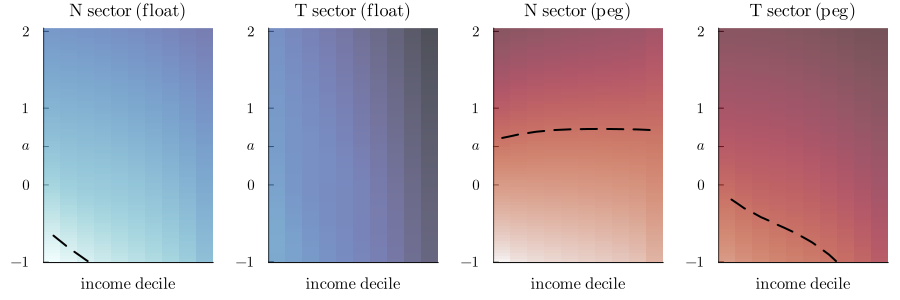

In [7]:
# compute the response for float
@load "transition_results/float.jld2"
res_float = res_this

@time paral = pmap(q_response,[value_N,value_T],[distr_N,distr_T],(1-par.τ_w)*[res_float.wN_sequence,res_float.wT_sequence],[res_float.rd_sequence,res_float.rd_sequence],[zeros(L),zeros(L)],[true,true],[par,par],[par_grid_N,par_grid_T],[t_grid,t_grid])
Call_N_float, Lall_N_float, Wall_N_float = paral[1]
Call_T_float, Lall_T_float, Wall_T_float = paral[2]

# compute the response for peg
@load "transition_results/peg.jld2"
res_peg = res_this

@time paral = pmap(q_response,[value_N,value_T],[distr_N,distr_T],(1-par.τ_w)*[res_peg.wN_sequence,res_peg.wT_sequence],[res_peg.rd_sequence,res_peg.rd_sequence],[zeros(L),zeros(L)],[true,true],[par,par],[par_grid_N,par_grid_T],[t_grid,t_grid])
Call_N_peg, Lall_N_peg, Wall_N_peg = paral[1]
Call_T_peg, Lall_T_peg, Wall_T_peg = paral[2]

# compute welfare gains
gain_N_float = reshape(Wall_N_float-value_N,par_grid.N,par_grid.K)
gain_N_peg = reshape(Wall_N_peg-value_N,par_grid.N,par_grid.K)
gain_T_float = reshape(Wall_T_float-value_T,par_grid.N,par_grid.K)
gain_T_peg = reshape(Wall_T_peg-value_T,par_grid.N,par_grid.K)
z = findfirst(q->par_grid.q_grid[q]/a>2,1:par_grid.N)

# make plots
clims = extrema([gain_N_float[1:z,:];gain_T_float[1:z,:]])
plot_N_float = heatmap((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_N_float[1:z,:],c=cgrad(:ice,rev=true),title=L"\mathrm{N\ sector\ (float)}",alpha=0.7,grid=:false,clims=clims,colorbar=false)
plot!((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_N_float[1:z,:],levels=[1e-5],st=:contour,color=:black,colorbar=false,lw=2,ls=:dash)
plot_T_float = heatmap((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_T_float[1:z,:],c=cgrad(:ice,rev=true),title=L"\mathrm{T\ sector\ (float)}",alpha=0.7,grid=:false,clims=clims,colorbar=false)
plot!((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_T_float[1:z,:],levels=[1e-5],st=:contour,color=:black,lw=2,ls=:dash,colorbar=false)
clims = extrema([gain_N_peg[1:z,:];gain_T_peg[1:z,:]])
plot_N_peg = heatmap((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_N_peg[1:z,:],c=:amp,title=L"\mathrm{N\ sector\ (peg)}",alpha=0.7,grid=:false,clims=clims,colorbar=false)
plot!((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_N_peg[1:z,:],levels=[1e-5],st=:contour,color=:black,colorbar=false,lw=2,ls=:dash)
plot_T_peg = heatmap((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_T_peg[1:z,:],c=:amp,title=L"\mathrm{T\ sector\ (peg)}",alpha=0.7,grid=:false,clims=clims,colorbar=false)
plot!((1:par_grid.K),par_grid.q_grid[1:z]/a,gain_T_peg[1:z,:],levels=[1e-5],st=:contour,color=:black,lw=2,ls=:dash,colorbar=false)
l = @layout[a a a a]

plot(plot_N_float,plot_T_float,plot_N_peg,plot_T_peg,layout=l,size=(900,300),xticks=:false,yticks=([-1;0;0.5;1;2],[L"-1",L"0",L"a",L"1",L"2"]),xlabel=L"\mathrm{income\ decile}",
    bottom_margin=0.5Plots.cm,top_margin=0.25Plots.cm,tickfontsize=10,titlefontsize=12)

In [8]:
png("graphs/welfare_gains.png")

"graphs/welfare_gains.png"